# Machine Learning with PySpark MLlib
PySpark MLlib is the Apache Spark scalable machine learning library in Python consisting of common learning algorithms and utilities. Throughout this last chapter, you'll learn important Machine Learning algorithms. You will build a movie recommendation engine and a spam filter, and use k-means clustering.

## PySpark MLlib algorithms
Before using any Machine learning algorithms in PySpark shell, you'll have to import the submodules of pyspark.mllib library and then choose the appropriate class that is needed for a specific machine learning task.

In this simple exercise, you'll learn how to import the different submodules of pyspark.mllib along with the classes that are needed for performing Collaborative filtering, Classification and Clustering algorithms.

In [2]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS

# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

## Loading Movie Lens dataset into RDDs
Collaborative filtering is a technique for recommender systems wherein users' ratings and interactions with various products are used to recommend new ones. With the advent of Machine Learning and parallelized processing of data, Recommender systems have become widely popular in recent years, and are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags. In this 3-part exercise, your goal is to develop a simple movie recommendation system using PySpark MLlib using a subset of MovieLens 100k dataset.

In the first part, you'll first load the MovieLens data (ratings.csv) into RDD and from each line in the RDD which is formatted as userId,movieId,rating,timestamp, you'll need to map the MovieLens data to a Ratings object (userID, productID, rating) after removing timestamp column and finally you'll split the RDD into training and test RDDs.

In [ ]:
from pyspark.mllib.recommendation import Rating

# File Path
file_path = ".../data/datacamp/movie"

# Load the data into RDD
data = sc.textFile(file_path)

# Split the RDD 
ratings = data.map(lambda l: l.split(','))

# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))

# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

## Model training and predictions
After splitting the data into training and test data, in the second part of the exercise, you'll train the ALS algorithm using the training data. PySpark MLlib's ALS algorithm has the following mandatory parameters - rank (the number of latent factors in the model) and iterations (number of iterations to run). After training the ALS model, you can use the model to predict the ratings from the test data. For this, you will provide the user and item columns from the test dataset and finally print the first 2 rows of predictAll() output.

In [ ]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=1)

# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

# Predict the model  
predictions = model.predictAll(testdata_no_rating)

# Print the first rows of the RDD
predictions.take(2)

## Model evaluation using MSE
After generating the predicted ratings from the test data using ALS model, in this final part of the exercise, you'll prepare the data for calculating Mean Square Error (MSE) of the model. The MSE is the average value of (original rating – predicted rating)^2 for all users and indicates the absolute fit of the model to the data. To do this, first, you'll organize both the ratings and prediction RDDs to make a tuple of ((user, product), rating)), then join the ratings RDD with prediction RDD and finally apply a squared difference function along with mean() to get the MSE.

In [ ]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)

# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE)) # Mean Squared Error of the model for the test data = 1.35

## Loading spam and non-spam data
Logistic Regression is a popular method to predict a categorical response. Probably one of the most common applications of the logistic regression is the message or email spam classification. In this 3-part exercise, you'll create an email spam classifier with logistic regression using Spark MLlib. Here are the brief steps for creating a spam classifier.

- Create an RDD of strings representing email.
- Run MLlib’s feature extraction algorithms to convert text into an RDD of vectors.
- Call a classification algorithm on the RDD of vectors to return a model object to classify new points.
- Evaluate the model on a test dataset using one of MLlib’s evaluation functions.

In the first part of the exercise, you'll load the 'spam' and 'ham' (non-spam) files into RDDs, split the emails into individual words and look at the first element in each of the RDD.

In [ ]:
# Paths to files
file_path_spam = ".../data/datacamp/spam"
file_path_non_spam = ".../data/datacamp/no_spam"

# Load the datasets into RDDs
spam_rdd = sc.textFile(file_path_spam)
non_spam_rdd = sc.textFile(file_path_non_spam)

# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

## Feature hashing and LabelPoint
After splitting the emails into words, our raw data set of 'spam' and 'non-spam' is currently composed of 1-line messages consisting of spam and non-spam messages. In order to classify these messages, we need to convert text into features.

In the second part of the exercise, you'll first create a HashingTF() instance to map text to vectors of 200 features, then for each message in 'spam' and 'non-spam' files you'll split them into words, and each word is mapped to one feature. These are the features that will be used to decide whether a message is 'spam' or 'non-spam'. Next, you'll create labels for features. For a valid message, the label will be 0 (i.e. the message is not spam) and for a 'spam' message, the label will be 1 (i.e. the message is spam). Finally, you'll combine both the labeled datasets.

In [ ]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint

# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features:LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features:LabeledPoint(0, features))

# Combine the two datasets
samples = spam_samples.join(non_spam_samples)

## Logistic Regression model training
After creating labels and features for the data, we’re ready to build a model that can learn from it (training). But before you train the model, you'll split the combined dataset into training and testing dataset because it can assign a probability of being spam to each data point. We can then decide to classify messages as spam or not, depending on how high the probability.

In this final part of the exercise, you'll split the data into training and test, run Logistic Regression on the training data, apply the same HashingTF() feature transformation to get vectors on a positive example (spam) and a negative one (non-spam) and finally check the accuracy of the model trained.

In [ ]:
train_samples.first()

In [ ]:
# Split the data into training and testing
train_samples,test_samples = samples.randomSplit([0.8, 0.2])

# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

## Loading and parsing the 5000 points data
Clustering is the unsupervised learning task that involves grouping objects into clusters of high similarity. Unlike the supervised tasks, where data is labeled, clustering can be used to make sense of unlabeled data. PySpark MLlib includes the popular K-means algorithm for clustering. In this 3 part exercise, you'll find out how many clusters are there in a dataset containing 5000 rows and 2 columns. For this you'll first load the data into an RDD, parse the RDD based on the delimiter, run the KMeans model, evaluate the model and finally visualize the clusters.

In the first part, you'll load the data into RDD, parse the RDD based on the delimiter and convert the string type of the data to an integer.

In [13]:
# Paths to files
file_path = ".../data/datacamp/kmeans/5000_points.txt"

# Load the dataset into a RDD
clusterRDD = sc.textFile(file_path)

# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split('\t'))

# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


## K-means training
Now that the RDD is ready for training, in the second part of the exercise, you'll train the RDD with PySpark's MLlib's KMeans algorithm. The algorithm is somewhat naive--it clusters the data into k clusters, even if k is not the right number of clusters to use. Therefore, when using k-means clustering, the most important parameter is a target number of clusters to generate, k. In practice, you rarely know the “true” number of clusters in advance, so the best practice is to try several values of k until the average intracluster distance stops decreasing dramatically

In this 2nd part, you'll test with k's ranging from 13 to 16 and use the elbow method to chose the correct k. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k, calculate Within Set Sum of Squared Error (WSSSE, this function is already provided to you) and select the best k based on the sudden drop in WSSSE. Finally, you'll retrain the model with the best k (15 in this case) and print the centroids (cluster centers).

In [15]:
from math import sqrt

def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

# Train the model with clusters from 13 to 16 and compute WSSSE 
for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

# Train the model again with the best k 
model = KMeans.train(rdd_split_int, k=15, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters

The cluster 13 has Within Set Sum of Squared Error 249164132.49410182
The cluster 14 has Within Set Sum of Squared Error 209371154.24941802
The cluster 15 has Within Set Sum of Squared Error 169394691.52639425
The cluster 16 has Within Set Sum of Squared Error 202384225.6640126


## Visualizing clusters
After KMeans model training with an optimum K value (K = 15), in this final part of the exercise, you will visualize the clusters and their cluster centers (centroids) and see if they overlap with each other. For this, you'll first convert rdd_split_int RDD into spark DataFrame and then into Pandas DataFrame for plotting. Similarly, you'll convert cluster_centers into Pandas DataFrame. Once the DataFrames are created, you'll use matplotlib library to create scatter plots.

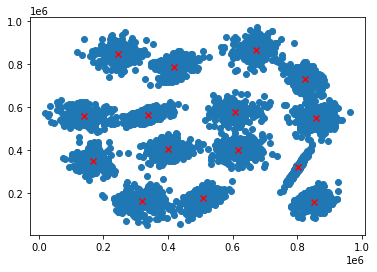

In [18]:
%matplotlib inline
from pandas import DataFrame
from matplotlib import pyplot as plt

# Convert rdd_split_int RDD into Spark DataFrame
rdd_split_int_df = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"])

# Convert Spark DataFrame into Pandas DataFrame
rdd_split_int_df_pandas = rdd_split_int_df.toPandas()

# Convert "cluster_centers" that you generated earlier into Pandas DataFrame
cluster_centers_pandas = DataFrame(model.clusterCenters, columns=["col1", "col2"])

# Create an overlaid scatter plot
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()